<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >

# Simple ergonomics indicator

- box-chest distance
- box inclination
- hip-floor distance

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt

# from pyosim import Conf
from pyomeca import Markers3d, Analogs3d, FrameDependentNpArray
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim/")

In [4]:
def correct_path(x):
    return Path(
        x.replace("home/laboratoire/mnt/E", "/media/romain/E")
        #         .replace("E:", "/media/romain/E")
        .replace("1_inverse_kinematic", "0_markers")
        .replace(".mot", ".trc")
        .replace("wu_expertsnovicesD_", "")
        .replace("wu_expertsnovicesG_", "")
    )


def parse_conditions(d):
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
        n_trial=lambda x: x["filename"].str.split("_").str[-1],
    )

In [5]:
box_markers = [
    "front_r_X",
    "front_r_Y",
    "front_r_Z",
    "mid_r_X",
    "mid_r_Y",
    "mid_r_Z",
    "back_r_X",
    "back_r_Y",
    "back_r_Z",
    "back_l_X",
    "back_l_Y",
    "back_l_Z",
    "front_l_X",
    "front_l_Y",
    "front_l_Z",
]


def box_thorax_distance(x):
    box = pd.concat(
        [x[box_markers].filter(like=i).mean(axis=1).rename(i) for i in ["X", "Y"]],
        axis=1,
    )
    thorax = x.filter(like="STER_").rename(columns=lambda x: x.replace("STER_", ""))
    return (
        np.sqrt(((box - thorax) ** 2).sum(axis=1))
        .replace(0, np.nan)
        .interpolate()
        .rename("box_thorax")
        .to_frame()
    )

In [6]:
hip_markers = [
    "ASISl_X",
    "ASISl_Y",
    "ASISl_Z",
    "ASISr_X",
    "ASISr_Y",
    "ASISr_Z",
    "PSISl_X",
    "PSISl_Y",
    "PSISl_Z",
    "PSISr_X",
    "PSISr_Y",
    "PSISr_Z",
]


def hip_normalized_displacement(x):
    hip = x[hip_markers].filter(like="Z").mean(axis=1)
    #     ref = hip.loc[0]

    p = x.loc[0, "participant"]
    kwargs = dict(
        header=3,
        first_row=6,
        first_column=1,
        time_column=1,
        delimiter="\t",
        last_column_to_remove=1,
    )
    try:
        try:
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}d0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
        except IndexError:
            kwargs["last_column_to_remove"] = 0
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}d0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
    except FileNotFoundError:
        try:
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}g0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )
        except IndexError:
            kwargs["last_column_to_remove"] = 0
            ref = (
                Markers3d.from_csv(
                    f"{project_path}/{p}/0_markers/irssten_{p}g0.trc", **kwargs
                )
                .to_dataframe()[hip_markers]
                .filter(like="Z")
                .mean(axis=1)
                .mean()
            )

    return (
        (hip - ref)
        .replace(0, np.nan)
        .interpolate()
        .rename("hip_displacement")
        .to_frame()
    )

In [7]:
# x = Markers3d.from_csv(
#     filename,
#     header=3,
#     first_row=6,
#     first_column=1,
#     time_column=1,
#     delimiter="\t",
#     last_column_to_remove=1,
# )
# idx = np.logical_and(
#     x.get_time_frames < ifile["offset"], x.get_time_frames > ifile["onset"]
# )
# x = (
#     x[..., idx]
#     .to_dataframe()
#     .assign(
#         filename=filename.stem,
#         participant=filename.parent.parent.stem,
#         time=lambda x: x.index / 100,
#     )
# )

In [8]:
clav_markers = [
    "CLAV_SC_X",
    "CLAV_SC_Y",
    "CLAV_SC_Z",
    "CLAV_ACm_X",
    "CLAV_ACm_Y",
    "CLAV_ACm_Z",
    "SCAP_CP_X",
    "SCAP_CP_Y",
    "SCAP_CP_Z",
    "SCAP_AA_X",
    "SCAP_AA_Y",
    "SCAP_AA_Z",
]


def phase_duration(x):
    total_duration = x["time"].iloc[-1]

    box = x[["back_r_Y", "back_l_Y"]].mean(axis=1)
    first_phase = box < box.head(10).mean() - 100
    first_phase_duration = x.loc[first_phase, "time"].iloc[0]

    second_phase = x[box_markers].filter(like="Z").mean(axis=1).sub(200) > x[
        clav_markers
    ].filter(like="Z").mean(axis=1)
    second_phase_duration = x.loc[second_phase, "time"].iloc[0] - first_phase_duration

    third_phase_duration = total_duration - (
        first_phase_duration + second_phase_duration
    )

    return pd.Series(
        [
            first_phase_duration,
            second_phase_duration,
            third_phase_duration,
            total_duration,
        ],
        index=["first", "second", "third", "total"],
    )

## Box-chest distance

In [9]:
markers = []
f = []
onsets = pd.read_csv(project_path / "onsets.csv")
for _, ifile in onsets.iterrows():
    filename = correct_path(ifile["filepathK"])
    if filename in f:
        continue
    else:
        f.append(filename)
    try:
        e = Markers3d.from_csv(
            filename,
            header=3,
            first_row=6,
            first_column=1,
            time_column=1,
            delimiter="\t",
            last_column_to_remove=1,
        )
    except FileNotFoundError:
        print(f"{filename} not found")
        continue

    idx = np.logical_and(
        e.get_time_frames < ifile["offset"], e.get_time_frames > ifile["onset"]
    )

    markers.append(
        e[..., idx]
        .time_normalization()
        .to_dataframe()
        .assign(
            filename=filename.stem,
            participant=filename.parent.parent.stem,
            box_thorax=lambda x: box_thorax_distance(x),
            hip_displacement=lambda x: hip_normalized_displacement(x),
            box_height=lambda x: x[box_markers].filter(like="Z").mean(axis=1),
            box_speed=lambda x: x[box_markers].filter(like="Z").mean(axis=1).diff(),
            time=FrameDependentNpArray(e.get_time_frames.reshape(1, 1, -1))
            .time_normalization()
            .squeeze(),
        )
    )
markers = (
    pd.concat(markers)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .pipe(parse_conditions)
    .query('fatigue == 0 & height == "r"')
    .drop("fatigue", axis=1)
)

markers.sample(5)

/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_markers/1_r12_1.trc  not found
/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_markers/1_r12_2.trc  not found


,index,ASISl_X,ASISl_Y,ASISl_Z,ASISr_X,ASISr_Y,ASISr_Z,PSISr_X,PSISr_Y,PSISr_Z,...,participant,box_thorax,hip_displacement,box_height,box_speed,time,expert,height,mass,n_trial
46957,0.93,794.554432,-1069.905242,358.342060,593.842402,-1134.171364,342.044216,581.606752,-953.625276,375.341880,...,sylg,410.722972,20.770031,1185.143667,-1.707645,5.7567,0,r,8,6
928,0.19,968.831792,-372.773292,265.376768,NaN,NaN,NaN,1178.049204,-238.327276,335.527972,...,antc,NaN,-11.614276,376.931537,21.739490,1.2426,0,r,8,5
3464,0.30,900.098200,-424.562000,254.177400,878.811100,-190.522500,256.726100,1054.976200,-258.176700,286.102000,...,beng,238.016652,5.108768,429.190640,14.608020,2.3940,0,r,8,6
13413,0.81,849.142321,-1018.998331,423.307117,555.682480,-1021.658017,424.389867,658.399628,-860.824375,427.015183,...,didl,446.460138,37.349377,1298.639993,-1.526579,5.9130,0,r,8,3
42813,0.90,993.465800,-932.455000,272.317800,729.972400,-929.643900,279.947000,844.913800,-784.293700,304.279400,...,samc,515.417434,18.219732,1077.883760,0.525912,4.2930,0,r,8,6


In [10]:
height = (
    pd.read_csv(project_path / "_conf.csv")
    .query("process == 1")[["participant", "height"]]
    .rename(columns={"height": "p_height"})
)

In [11]:
data = (
    markers.merge(height, on="participant", how="left")
    .eval("box_thorax = box_thorax / (p_height * 10)")
    .eval("hip_displacement = hip_displacement / (p_height * 10)")
    .drop("p_height", axis=1)
    #     .dropna()
)

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [12]:
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       72
        12      79
1       8       50
        12      39
dtype: int64

In [13]:
balanced_trials = random_balanced_design(
    data, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [14]:
data = data.query("filename == @_filename & participant == @_participant")
data.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

### Stats

In [142]:
id_vars = ["filename", "participant", "expert", "height", "mass", "n_trial", "index"]
value = "box_thorax"
# value = "hip_displacement"
value = "box_height"
stats_df = (
    data[id_vars]
    .assign(value=data[value])
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
stats_df = stats_df.fillna(stats_df.mean())
stats_df

value            \
index                                                    0.00      0.01   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.000278  0.000211   
antc_1_r08_4 0           0      r      8    4        0.000039  0.000075   
antc_1_r08_5 0           0      r      8    5        0.000000  0.000003   
antc_1_r08_6 0           0      r      8    6        0.000509  0.000508   
antc_1_r12_1 0           0      r      12   1        0.001926  0.002000   
...                                                       ...       ...   
stec_1_r12_5 22          1      r      12   5        0.004340  0.004374   
sylg_1_r08_4 23          0      r      8    4        0.000000  0.000090   
sylg_1_r08_6 23          0      r      8    6        0.000000  0.000002   
sylg_1_r12_1 23          0      r      12   1        0.000000  0.000110   
sylg_1_r12_6 23          0      r      12   6        0.000025  0.000000   

                                                                         \
index                                                    0.02      0.03   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.000140  0.000088   
antc_1_r08_4 0           0      r      8    4        0.000000  0.000002   
antc_1_r08_5 0           0      r      8    5        0.000021  0.000255   
antc_1_r08_6 0           0      r      8    6        0.000491  0.000496   
antc_1_r12_1 0           0      r      12   1        0.002135  0.001913   
...                                                       ...       ...   
stec_1_r12_5 22          1      r      12   5        0.004216  0.004274   
sylg_1_r08_4 23          0      r      8    4        0.000415  0.001131   
sylg_1_r08_6 23          0      r      8    6        0.000073  0.000425   
sylg_1_r12_1 23          0      r      12   1        0.000345  0.000547   
sylg_1_r12_6 23          0      r      12   6        0.000068  0.000223   

                                                                         \
index                                                    0.04      0.05   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.000000  0.000060   
antc_1_r08_4 0           0      r      8    4        0.000174  0.000409   
antc_1_r08_5 0           0      r      8    5        0.000531  0.001635   
antc_1_r08_6 0           0      r      8    6        0.000447  0.000460   
antc_1_r12_1 0           0      r      12   1        0.001548  0.000823   
...                                                       ...       ...   
stec_1_r12_5 22          1      r      12   5        0.004089  0.003961   
sylg_1_r08_4 23          0      r      8    4        0.002679  0.006162   
sylg_1_r08_6 23          0      r      8    6        0.000505  0.000630   
sylg_1_r12_1 23          0      r      12   1        0.000838  0.001557   
sylg_1_r12_6 23          0      r      12   6        0.000484  0.000806   

                                                                         \
index                                                    0.06      0.07   
filename     participant expert height mass n_trial                       
antc_1_r08_1 0           0      r      8    1        0.000200  0.000267   
antc_1_r08_4 0           0      r      8    4        0.001154  0.003348   
antc_1_r08_5 0           0      r      8    5        0.003775  0.008090   
antc_1_r08_6 0           0      r      8    6        0.000348  0.000358   
antc_1_r12_1 0           0      r      12   1        0.000431  0.000141   
...                                                       ...       ...   
stec_1_r12_5 22          1      r      12   5        0.003646  0.003251   
sylg_1_r08_4 23          0      r      8    4        0.011364  0.017899   
sylg_1_r08_6 23          0      r      8    6        0.001212  0.002860   
syl

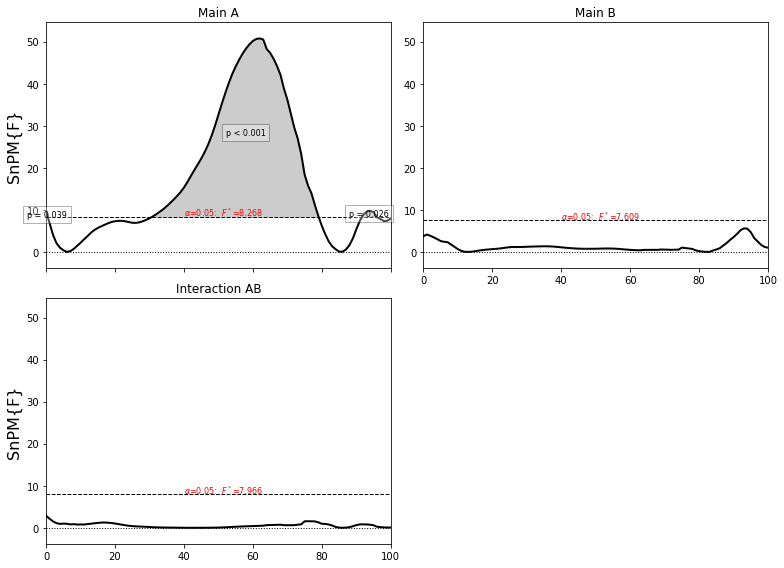

In [143]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    stats_df.to_numpy(),
    A=stats_df.index.get_level_values("expert"),
    B=stats_df.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [144]:
effect = {
    "Main A": "main sex",
    "Main B": "main mass",
    "Interaction AB": "interaction sex-mass",
}

clusters = get_spm_cluster(spmi, labels=effect, mult=1 / stats_df.shape[1])
clusters

,effect,p,start,end
0,main sex,0.0393333,0,0.00473227
1,main sex,0,0.302663,0.783289
2,main sex,0.026,0.907323,0.950176


In [145]:
effect = {"main sex": "expert", "main mass": "mass", "interaction sex-mass": "expert"}
clusters = describe_clusters(
    clusters, data[id_vars + [value]].rename(columns=dict(hip_displacement="box_thorax")), effect
)
clusters

KeyError: 'Column not found: value'

In [146]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [147]:
base = alt.Chart(data[id_vars + [value]]).encode(
    alt.X(
        "index", title="normalized trial", axis=alt.Axis(format="%", labelFlush=False)
    )
)
mu = base.mark_line().encode(
    alt.Y(
        f"mean({value})",
        title="box-thorax distance (% height)",
        axis=alt.Axis(format="%"),
    )
)
sigma = base.mark_errorband(extent="ci").encode(alt.Y(value, title=None))
men_scale = alt.Scale(scheme="set1")

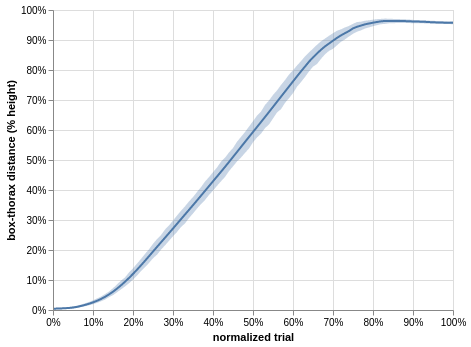

In [148]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

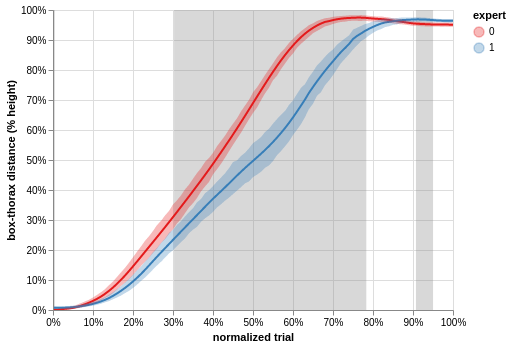

In [149]:
c.transform_filter('datum.effect == "main sex"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

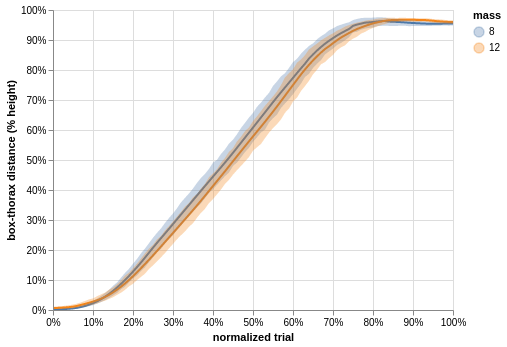

In [150]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

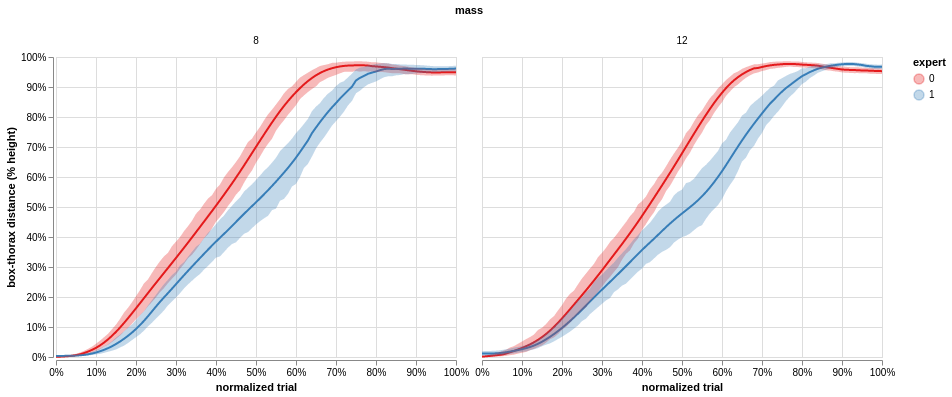

In [151]:
(mu + sigma).encode(alt.Color("expert:N", scale=men_scale)).facet(column="mass")

In [128]:
data["box_height"] = data.groupby("filename")["box_height"].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [ ]:
alt.Chart(data[id_vars + ['box_height']]).mark_line()

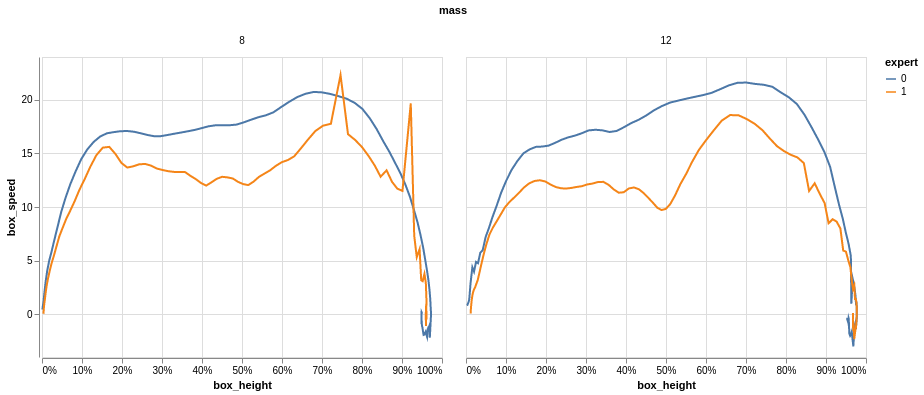

In [153]:
alt.Chart(
    data[id_vars + ["box_speed", "box_height"]]
    .groupby(["expert", "mass", "index"])["box_speed", "box_height"]
    .mean()
    .reset_index()
).mark_line().encode(
    alt.X("box_height", axis=alt.Axis(format="%")),
    alt.Y("box_speed"),
    alt.Color("expert:N"),
    alt.Order("index"),
    alt.Column("mass"),
)

## Task duration

In [16]:
duration = (
    data.groupby(["filename", "participant", "expert", "mass"])
    .apply(phase_duration)
    .reset_index()
    .dropna()
)

In [24]:
spmi.get_h0reject_values

('Main A', 'Main B', 'Interaction AB')

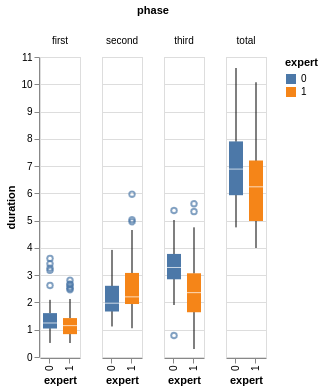

In [34]:
alt.Chart(
    duration.melt(
        id_vars=["filename", "participant", "expert", "mass"],
        var_name="phase",
        value_name="duration",
    )
).mark_boxplot().encode(
    alt.X("expert:N"), alt.Y("duration"), alt.Color("expert:N"), alt.Column("phase")
)

In [26]:
α = 0.05
n_iter = 1000

for phase in ["first", "second", "third", "total"]:
    spm = spm1d.stats.nonparam.anova2(
        duration["first"], A=duration["expert"], B=duration["mass"],
    )
    spmi = spm.inference(alpha=α, iterations=n_iter)
    print(f"{phase.upper()} phase")
    print(f"{spmi}")
    for effect, h0 in zip(spmi.get_effect_labels(), spmi.get_h0reject_values()):
        print(f"\t{effect} h0 rejected: {h0}")
    print("-" * 20)

FIRST phase
SnPM{F} inference list (0D)
   design      :  ANOVA2
   nEffects    :  3
   nPermUnique :  7.471e+275 permutations possible
   nPermActual :  1000
Effects:
   A     F = 3.426    p = 0.061
   B     F = 0.026    p = 0.878
   AB    F = 2.266    p = 0.129

	Main A h0 rejected: False
	Main B h0 rejected: False
	Interaction AB h0 rejected: False
--------------------
SECOND phase
SnPM{F} inference list (0D)
   design      :  ANOVA2
   nEffects    :  3
   nPermUnique :  7.471e+275 permutations possible
   nPermActual :  1000
Effects:
   A     F = 3.426    p = 0.062
   B     F = 0.026    p = 0.876
   AB    F = 2.266    p = 0.130

	Main A h0 rejected: False
	Main B h0 rejected: False
	Interaction AB h0 rejected: False
--------------------
THIRD phase
SnPM{F} inference list (0D)
   design      :  ANOVA2
   nEffects    :  3
   nPermUnique :  7.471e+275 permutations possible
   nPermActual :  1000
Effects:
   A     F = 3.426    p = 0.072
   B     F = 0.026    p = 0.872
   AB    F = 2.26

<!--NAVIGATION-->
< [Joint reactions](02.02-joint-reactions.ipynb) | [Contents](Index.ipynb) | [Analyses](03.00-experts-novices.ipynb) >